## AgB Eperiments
December, 2023
Experiments by jmchan@lbl.gov, awojdyla@lbl.gov

The Pilatus deector is now about 1000 mm from the sample position

We do not use bluesky -- just epics call through python.

partial log: go.lbl.gov/bl531/log2023

In [1]:
import epics
import numpy
from PIL import Image

In [14]:
# testing EPICS with the monochromator
mono_angle_deg = 26
epics.caput('bl531_xps1:mono_angle_deg',mono_angle_deg)

1

In [22]:
#testing EPICS
epics.caput('13PIL1:cam1:Acquire',1)
last_filename_ascii = epics.caget('13PIL1:cam1:FullFileName_RBV')
last_filename = bytes(last_filename_ascii).decode()

In [1]:
#read a image
import numpy as np
from PIL import Image

filepath = '/mnt/pilatus/' + last_filename[13:-1] 

# read the image
im_tiff = Image.open(filepath)
# make the image a numpy array so that we can process it
im_np = np.squeeze(np.array(im_tiff.getdata()).reshape(im_tiff.size[1], im_tiff.size[0], 1))

NameError: name 'last_filename' is not defined

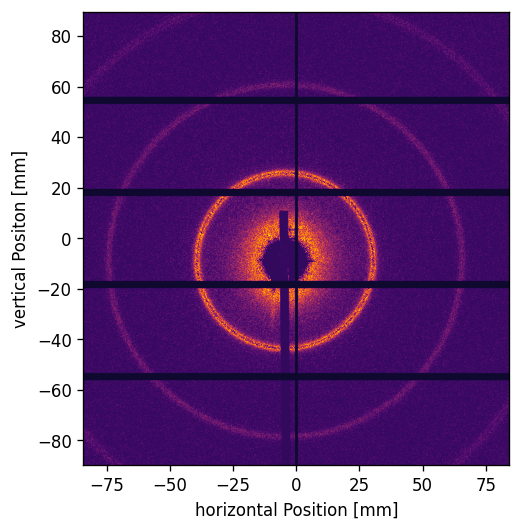

In [28]:
# dealing with dyanmic range
im_np[np.where(im_np>100000.0)] =0

import matplotlib.pyplot as plt
dx_m = 172e-6
Nx_px = 981
Ny_px = 1043
Dx_m = Nx_px*dx_m
Dy_m = Ny_px*dx_m

fig=plt.figure(figsize=(5, 5), dpi= 120, facecolor='w', edgecolor='k')
extent = (-Dx_m/2 * 1e3, +Dx_m/2 * 1e3, -Dy_m/2 * 1e3, +Dy_m/2 * 1e3)

mask = im_np > np.max(im_np)
im_np[mask]=0

plt.imshow(im_np, extent=extent, cmap = 'inferno')
plt.xlabel('horizontal Position [mm]')
plt.ylabel('vertical Positon [mm]')
plt.show()

In [29]:
#physical constants
h_m2kgps = 6.6261e-34
c_mps    = 299792458   
e_eV     = 6.2415e+18
# Silicon spacing (for Bragg condition)
Si_m = 5.43E-10
a_Si111_m = Si_m/np.sqrt(1^2+1^2+1^2)
# Monochromotor offset
mono_offset_deg = 12.787
mono_offset_deg = 13.017 # new calibration
#Wavelength from energy
lambda_m = lambda E_eV : h_m2kgps*c_mps*e_eV/E_eV
#Bragg angle from Wavelength
bragg_deg = lambda E_eV: np.arcsin(lambda_m(E_eV)/(2*a_Si111_m))*180/np.pi
# Mono angle from Bragg angle
mono_deg = lambda E_eV: bragg_deg(E_eV)+mono_offset_deg
mono_deg(7000)

29.42576899316475

In [45]:
from time import sleep as time_sleep
# there's no settling time in EPICS so we use `sleep` to enforce a guard time after motion

Es_eV = np.linspace(9500, 3500, 61)
epics.caput('bl531_xps1:mono_angle_deg',mono_deg(Es_eV[0]))
time_sleep(10)
filenames = ()
for i_e in range(len(Es_eV)):
    mono_angle_deg = mono_deg(Es_eV[i_e])
    epics.caput('bl531_xps1:mono_angle_deg',mono_angle_deg)
    #print(mono_angle_deg)
    time_sleep(2)
    epics.caput('13PIL1:cam1:Acquire',1)
    last_filename_ascii = epics.caget('13PIL1:cam1:FullFileName_RBV')
    last_filename = bytes(last_filename_ascii).decode()[13:-1]
    filenames += (last_filename,)

In [57]:
filenames[0] 

'agb_20231220_160.tif'

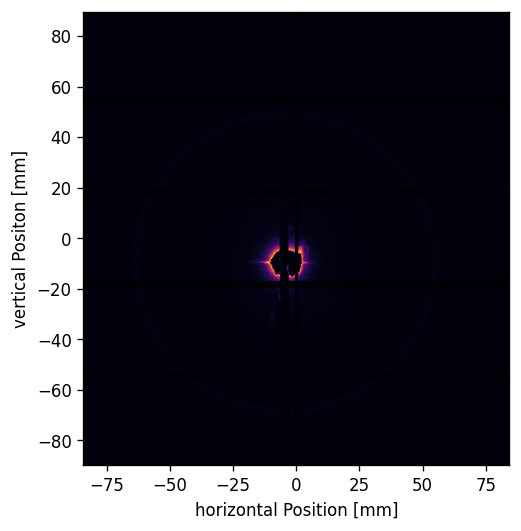

In [59]:
filepath = '/mnt/pilatus/' + filenames[44]

# read the image
im_tiff = Image.open(filepath)
# make the image a numpy array so that we can process it
im_np = np.squeeze(np.array(im_tiff.getdata()).reshape(im_tiff.size[1], im_tiff.size[0], 1))

# dealing with dyanmic range
im_np[np.where(im_np>100.0)] =0

import matplotlib.pyplot as plt
dx_m = 172e-6
Nx_px = 981
Ny_px = 1043
Dx_m = Nx_px*dx_m
Dy_m = Ny_px*dx_m

fig=plt.figure(figsize=(5, 5), dpi= 120, facecolor='w', edgecolor='k')
extent = (-Dx_m/2 * 1e3, +Dx_m/2 * 1e3, -Dy_m/2 * 1e3, +Dy_m/2 * 1e3)

mask = im_np > np.max(im_np)
im_np[mask]=0

plt.imshow(im_np, extent=extent, cmap = 'inferno')
plt.xlabel('horizontal Position [mm]')
plt.ylabel('vertical Positon [mm]')
plt.show()

In [60]:
img = ()
for i_e in range(len(Es_eV)):
    filepath = '/mnt/pilatus/' + filenames[i_e] 
    # read the image
    im_tiff = Image.open(filepath)
    # make the image a numpy array so that we can process it
    im_np = np.squeeze(np.array(im_tiff.getdata()).reshape(im_tiff.size[1], im_tiff.size[0], 1))
    img += (im_np,)


In [61]:
flux = Es_eV*0
for i_e in range(len(Es_eV)):
    flux[i_e] = np.sum(img[i_e])

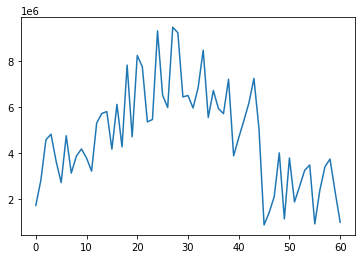

In [62]:
plt.plot(flux)

Text(0, 0.5, 'image number')

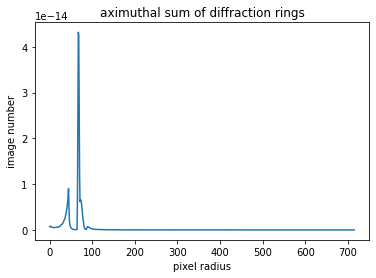

In [91]:
from skimage.transform import warp, warp_polar

im_warp = warp_polar(img[44], center=[466,574])
#1043, 981
im_warp = warp_polar(img[44], center=[1043-466,981-574])
plt.plot(np.sum(im_warp,axis=0))
plt.title('aximuthal sum of diffraction rings')
plt.xlabel('pixel radius')
plt.ylabel('image number')



In [92]:
np.shape(img)

(61, 1043, 981)

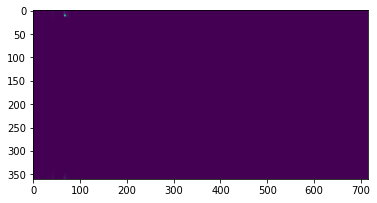

In [93]:
im_warp[im_warp>10]=0
plt.imshow(im_warp)
plt.show()

In [ ]:
# 120-149
# img_sum = ()
# for image in images:
#     #new_image = image_process_no_log(image)
#     new_image = image
#     im_warp = warp_polar(im_np, center=[526,564])
#     #plt.imshow(im_warp)
#     #plt.show()
#     img_sum += (im_warp,)

In [82]:
from skimage import io
#    #print(filepath)
#    img = io.imread(filepath)

#    images += (img,)

In [102]:
file_nb = 120+np.arange(30)
images = ()
for i_f in np.arange(len(file_nb)):
    folder = '/mnt/pilatus/'
    filename ='sample_20231117_%3.0f.tif' % file_nb[i_f]
    img = io.imread(folder+filename)
    images += (img,)


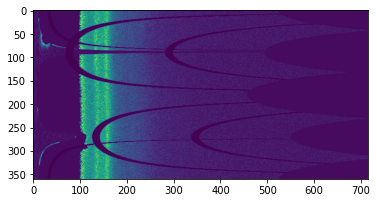

In [120]:
from skimage.transform import warp, warp_polar

#im_warp = warp_polar(images[-5], center=[564,526])
im_warp = warp_polar(images[-5], center=[549,456])



#displaying the azimathal dewarping (for center of been adjustment)
plt.imshow(im_warp)
plt.show()


Text(0, 0.5, 'image number')

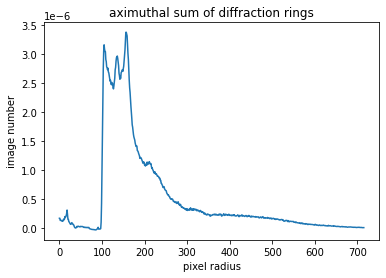

In [121]:
plt.plot(np.sum(im_warp,axis=0))
plt.title('aximuthal sum of diffraction rings')
plt.xlabel('pixel radius')
plt.ylabel('image number')

In [122]:
from skimage.transform import warp, warp_polar
img_sum = ()
for image in images:
    #new_image = image_process_no_log(image)
    new_image = image
    im_warp = warp_polar(new_image, center=[549,456])
    #plt.imshow(im_warp)
    #plt.show()
    img_sum += (im_warp,)

/tmp/ipykernel_603626/1861420229.py:2: RuntimeWarning: invalid value encountered in power
  plt.imshow(np.sum(img_sum,axis=1)**0.1, aspect=5)


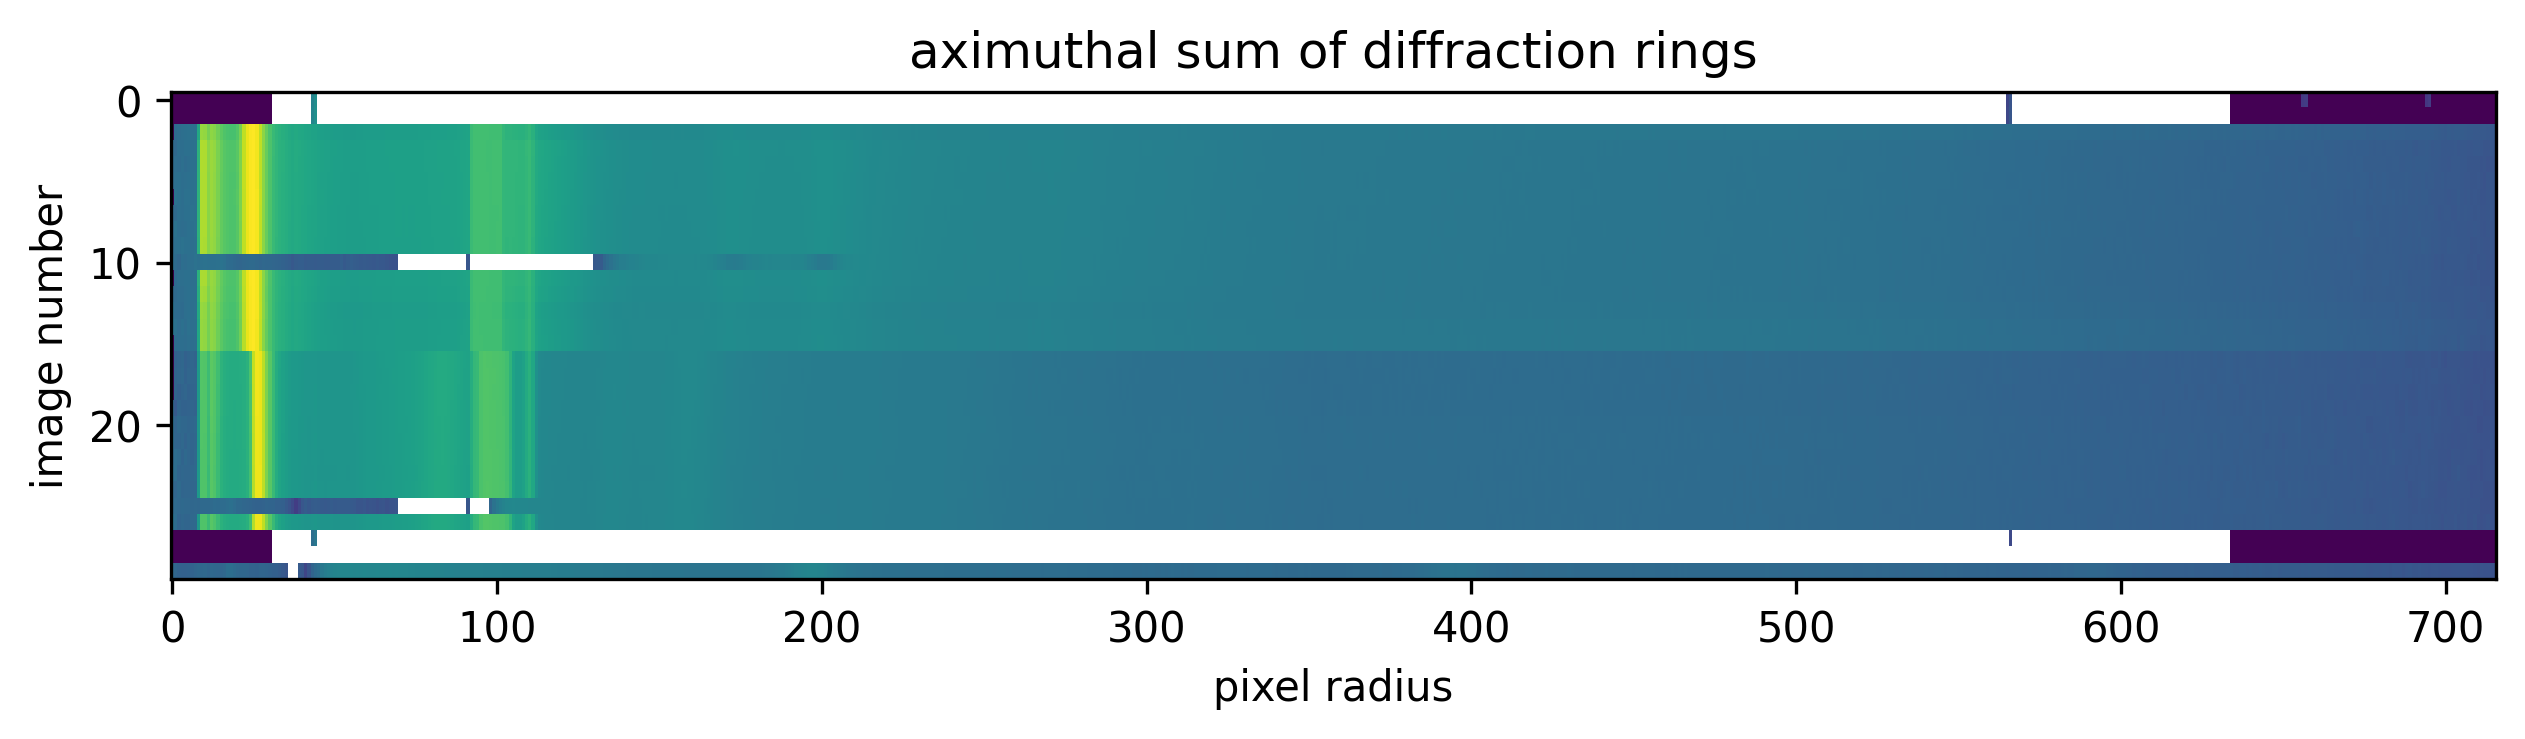

In [125]:
fig=plt.figure(figsize=(10, 10), dpi= 300, facecolor='w', edgecolor='k')
plt.imshow(np.sum(img_sum,axis=1)**0.1, aspect=5)
plt.title('aximuthal sum of diffraction rings')
plt.xlabel('pixel radius')
plt.ylabel('image number')
#plt.imshow(np.sum(np.sum(img_sum,axis=1),axis=0))

plt.show()

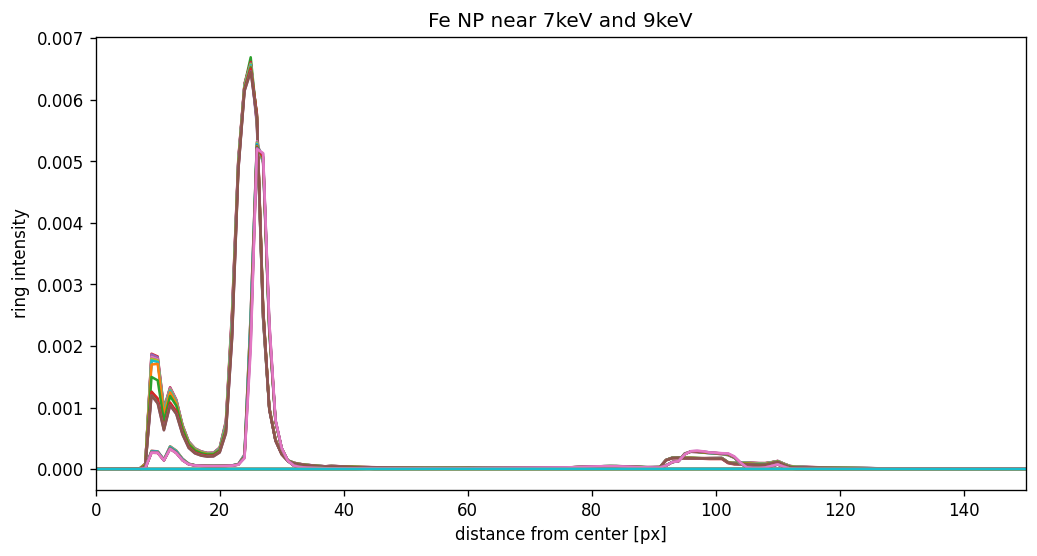

In [135]:
fig=plt.figure(figsize=(10, 5), dpi= 120, facecolor='w', edgecolor='k')
plt.plot(np.transpose(np.sum(img_sum,axis=1)))
plt.xlim([0,150])
plt.xlabel('distance from center [px]')
plt.ylabel('ring intensity')
plt.title('Fe NP near 7keV and 9keV')
plt.show()